In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import folium
from folium import plugins
from folium.features import CustomIcon
import googlemaps
import json
import pickle
import warnings

font_name = fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family=font_name)

warnings.filterwarnings(action='ignore')

In [2]:
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [3]:
SUV_Purchase = pd.read_csv("D:/jupyter/01.프로젝트/21.07_BMW_garage_startup/01.Data/SUV_Purchase.csv")

In [4]:
SUV_Purchase

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [5]:
SUV_Purchase.shape

(400, 5)

In [6]:
SUV_Purchase

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [7]:
SUV_Purchase.loc[:,"Age":'Purchased'].describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


In [8]:
SUV_Purchase["Purchased"].value_counts()

0    257
1    143
Name: Purchased, dtype: int64

In [9]:
SUV_Purchase.isna().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [10]:
SUV_Purchase.nunique()

User ID            400
Gender               2
Age                 43
EstimatedSalary    117
Purchased            2
dtype: int64

In [11]:
SUV_Purchase.loc[:,"Age":'Purchased'].corr()

,Age,EstimatedSalary,Purchased
Age,1.000000,0.155238,0.622454
EstimatedSalary,0.155238,1.000000,0.362083
Purchased,0.622454,0.362083,1.000000


<AxesSubplot:>

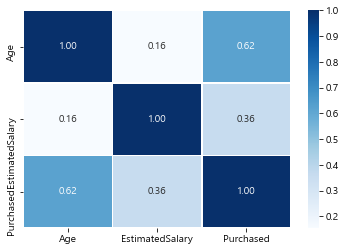

In [12]:
sns.heatmap(data = SUV_Purchase.loc[:,"Age":'Purchased'].corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

<AxesSubplot:>

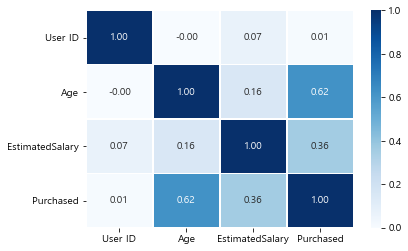

In [13]:
sns.heatmap(data = SUV_Purchase.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

<AxesSubplot:>

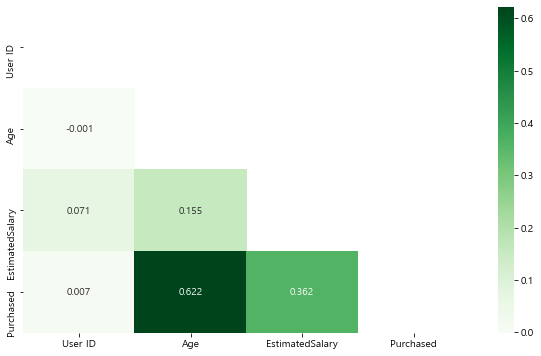

In [14]:
mask = np.zeros_like(SUV_Purchase.corr())
mask[np.triu_indices_from(mask)] = True
plt.rcParams["figure.figsize"] = (10,6) # 그림 크기 조정
sns.heatmap(data = SUV_Purchase.corr(), mask=mask, annot=True, fmt = '.3f', linewidths=0, cmap='Greens')

In [15]:
# 더미변수화 (원하는 컬럼만)
df2 = pd.get_dummies(SUV_Purchase, columns = ['Gender'])
df2

,User ID,Age,EstimatedSalary,Purchased,Gender_Female,Gender_Male
0,15624510,19,19000,0,0,1
1,15810944,35,20000,0,0,1
2,15668575,26,43000,0,1,0
3,15603246,27,57000,0,1,0
4,15804002,19,76000,0,0,1
...,...,...,...,...,...,...
395,15691863,46,41000,1,1,0
396,15706071,51,23000,1,0,1
397,15654296,50,20000,1,1,0
398,15755018,36,33000,0,0,1


In [16]:
# 데이터셋 구분 및 배열로 변환
data = df2[['Age','EstimatedSalary','Gender_Female','Gender_Male']].to_numpy()#독립변수
target= df2['Purchased'].to_numpy()#종속 변수

In [17]:
# 훈련, 테스트 세트 나누기 test_size default = 25%
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
data, target, test_size=0.2, random_state=42)

In [18]:
train_input.shape, test_input.shape

((320, 4), (80, 4))

In [19]:
# 검증 세트 만들기
#훈련세트 중에서 또다시 검증세트 20% 떼어내고 나머지를 훈련세트로 만들기
sub_input, val_input, sub_target, val_target = train_test_split(
train_input, train_target, test_size=0.2, random_state=42)

In [20]:
sub_input.shape, val_input.shape

((256, 4), (64, 4))

In [21]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

DecisionTreeClassifier(random_state=42)

In [22]:
dt.score(sub_input, sub_target)

0.99609375

In [23]:
dt.score(val_input, val_target)

0.875

In [24]:
from sklearn.model_selection import GridSearchCV
# 매개변수 설정 
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001), 
         'max_depth': range(5, 20, 1),
         'min_samples_split': range(2, 100, 10)}

In [83]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=1)
gs.fit(train_input, train_target)

# n_jobs=1로 했더니 UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128) 오류 해결
# 병렬처리 문제, dask는 pandas와 유사하지만 안정화 x, dask삭제
# msg = '{0}:{1}:{2}\n'.format(cmd, name, rtype).encode('utf-8')

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [84]:
gs.best_params_

{'max_depth': 5, 'min_impurity_decrease': 0.0001, 'min_samples_split': 12}

In [85]:
np.max(gs.cv_results_['mean_test_score'])

0.9

In [25]:
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [108]:
xgb_model = xgb.XGBClassifier(
    
    # General Parameter
    booster='gbtree', # 트리,회귀(gblinear) 트리가 항상 
                     # 더 좋은 성능을 내기 때문에 수정할 필요없다고한다.
    
    silent=True,  # running message출력안한다.
                 # 모델이 적합되는 과정을 이해하기위해선 False으로한다.
    
    min_child_weight=10,   # 값이 높아지면 under-fitting 되는 
                          # 경우가 있다. CV를 통해 튜닝되어야 한다.
    
    max_depth=8,     # 트리의 최대 깊이를 정의함. 
                    # 루트에서 가장 긴 노드의 거리.
                    # 8이면 중요변수에서 결론까지 변수가 9개거친다.
                    # Typical Value는 3-10. 
    
    gamma =0,    # 노드가 split 되기 위한 loss function의 값이
                # 감소하는 최소값을 정의한다. gamma 값이 높아질 수록 
                # 알고리즘은 보수적으로 변하고, loss function의 정의
                #에 따라 적정값이 달라지기때문에 반드시 튜닝.
    
    nthread =4,    # XGBoost를 실행하기 위한 병렬처리(쓰레드)
                  #갯수. 'n_jobs' 를 사용해라.
    
    colsample_bytree=0.8,   # 트리를 생성할때 훈련 데이터에서 
                           # 변수를 샘플링해주는 비율. 보통0.6~0.9
    
    colsample_bylevel=0.9,  # 트리의 레벨별로 훈련 데이터의 
                           #변수를 샘플링해주는 비율. 보통0.6~0.9
    
    n_estimators =(int),   #부스트트리의 양
                          # 트리의 갯수. 
    
    objective = 'reg:linear','binary:logistic','multi:softmax',
                'multi:softprob',  # 4가지 존재.
            # 회귀 경우 'reg', binary분류의 경우 'binary',
            # 다중분류경우 'multi'- 분류된 class를 return하는 경우 'softmax'
            # 각 class에 속할 확률을 return하는 경우 'softprob'
    
    random_state =  # random number seed.
                    # seed 와 동일.
)


In [26]:
from sklearn.model_selection import KFold,GridSearchCV
from xgboost import XGBClassifier



In [29]:
# 1번 2번

model=XGBClassifier()
param_grid={'booster' :['gbtree'],
                 #'silent':[True],
                 'max_depth':[5,6,8,10,20,40,80,100],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['binary:logistic','multi:softmax','multi:softprob'],
                 'random_state':[2]}

In [159]:
# 3번
cv=KFold(n_splits=30,shuffle=False)


In [160]:

# 4번
gcv=GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)

# 5번
gcv.fit(train_input,train_target)
print("----------------------------------------------------------------")
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력
print('best score', gcv.best_score_)      # 최고의 점수



[17:26:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
final params {'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.5, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 50, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 2}
best score 0.8718105968105969
